# Prediciting if an NFT is going to be Sold or Not Sold.

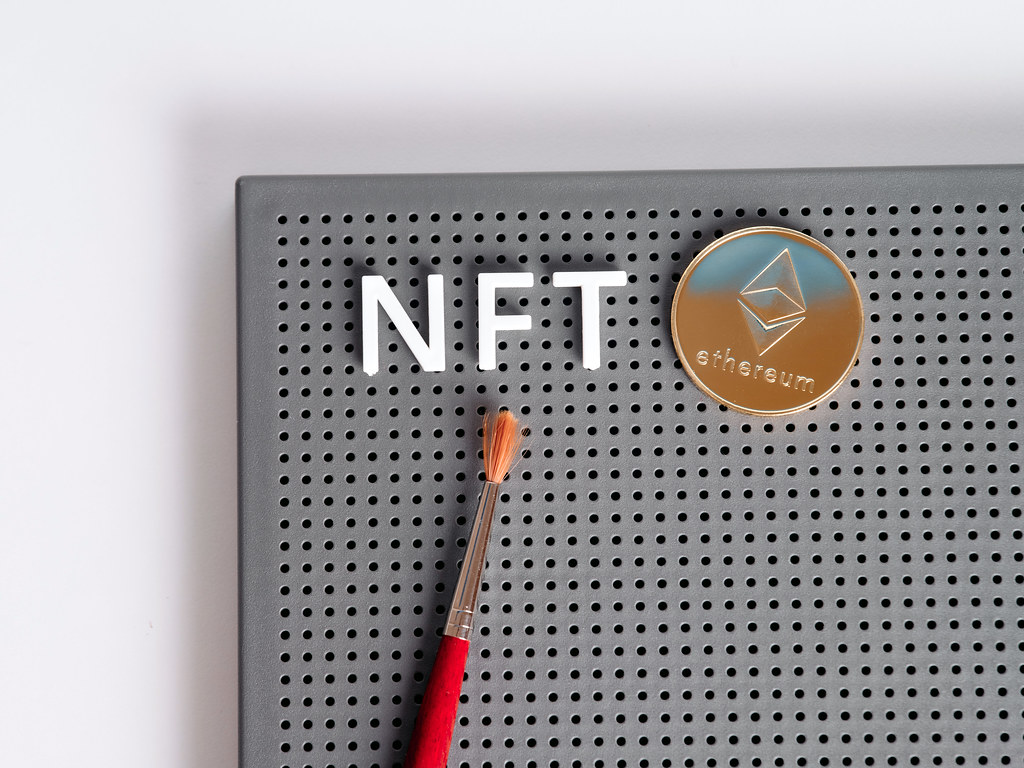

## Overview 

What’s an NFT? An NFT is a unit of data stored on a blockchain that certifies a digital
asset to be unique and therefore not interchangeable. The first popular example of NFTs is CryptoKitties, a collection of artistic images representing virtual cats that are used in a game on Ethereum that allows players to purchase, collect, breed, and sell them on Ethereum.

OpenSea is the largest marketplace for NFTs and, actually, acts as a 'marketplace for marketplaces'. Using their API, was able to gather about 44,000 data from 2018 to 2021. Then engineer the columns for the target class using the combination of the number of sales; sell orders and the lastsale.eventtype (all these are columns within the data). 

We recommend that if an NFT is created for sale or resell, opensea is an important place.

### Business Problem

30 million dollars, that was the market capitalization of NFts by the end of 2017 and as at this writing December 2021 according to financial mirror is valued at $43 billion. So for this increase in valuation signifies increase in value. For anything of value there will be creators and consumers. However, there are even fewer NFTs that is valuable. 
So how can creators be able to predict if the NFTs will be sold or not. 

To be able to answer we have to understand what error the model can make:
 - Type I Error (FP) = predicting an NFT will sell when it will not
-  Type II Error (FN) = predicting an NFT will not sell when it will

We need to try to reduce type I error for the seller to reduce time and effort however if type II error occurs. It wil be a plus to the seller.

### Data

OpenSea is a primary marketplace for other marketplaces, we gathered the data using its API and gathered about 30k rows and picking the most suitable. The columns of data contain many null values based on which columns are used by which marketplace. From the data was grouped into attributes of the token;the asset class and collections of other token like itself. The target was from three different columns because using one each creates imbalance and moreover keeping in mind that there were few NFTs that was sold more than once.

We decided to create binary columns for each feature. Alot of engineering went into the creation of binary columns with different approaches for boolean, integer, object using different techniques.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [3]:
pd.pandas.set_option('display.max_columns', None)
parse_dates = ['listing_date','asset_contract.created_date', 'collection.created_date']
nft_sale_df = pd.read_csv('nftsale.csv', low_memory=False, parse_dates=parse_dates)

In [4]:
nft_sale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14461 entries, 0 to 14460
Columns: 130 entries, Unnamed: 0 to transfer_fee_payment_token.usd_price
dtypes: bool(9), datetime64[ns](3), float64(25), int64(13), object(80)
memory usage: 13.5+ MB


In [5]:
nft_sale_df.describe()

,Unnamed: 0,id,num_sales,decimals,top_bid,transfer_fee_payment_token,asset_contract.owner,asset_contract.total_supply,asset_contract.dev_buyer_fee_basis_points,asset_contract.dev_seller_fee_basis_points,asset_contract.opensea_buyer_fee_basis_points,asset_contract.opensea_seller_fee_basis_points,asset_contract.buyer_fee_basis_points,asset_contract.seller_fee_basis_points,collection.dev_buyer_fee_basis_points,collection.dev_seller_fee_basis_points,collection.opensea_buyer_fee_basis_points,collection.opensea_seller_fee_basis_points,last_sale.asset.decimals,last_sale.asset_bundle,last_sale.payment_token.id,last_sale.payment_token.decimals,last_sale.payment_token.eth_price,last_sale.payment_token.usd_price,last_sale.transaction.block_number,last_sale.transaction.id,last_sale.transaction.transaction_index,last_sale.quantity,creator,last_sale.transaction.from_account.user,last_sale.transaction.to_account.user,owner.user,creator.user,last_sale,transfer_fee_payment_token.id,transfer_fee_payment_token.decimals,transfer_fee_payment_token.eth_price,transfer_fee_payment_token.usd_price
count,14461.000000,1.446100e+04,14461.000000,4000.0,0.0,0.0,1.165900e+04,1328.000000,14461.0,14461.000000,14461.0,14461.000000,14461.0,14461.000000,14461.0,14461.000000,14461.0,14461.000000,29.0,0.0,4184.000000,4184.000000,4178.000000,4178.000000,4.184000e+03,4.184000e+03,4184.000000,4152.000000,0.0,0.0,0.0,0.0,0.0,0.0,19.0,19.0,1.900000e+01,1.900000e+01
mean,9999.765438,6.189012e+07,28.478667,0.0,NaN,NaN,1.352265e+07,137.871235,0.0,136.289676,0.0,249.861697,0.0,386.151373,0.0,455.793790,0.0,249.861697,0.0,NaN,4.646750,17.919694,0.983943,3977.147082,1.314609e+07,1.677067e+08,167.816922,4.567678,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,1.453979e-03,3.830000e+00
std,5719.285690,4.724710e+07,194.379913,0.0,NaN,NaN,2.972555e+07,1146.537191,0.0,247.061572,0.0,5.878692,0.0,247.060855,0.0,384.439182,0.0,5.878692,0.0,NaN,33.551677,0.970645,0.126018,513.055590,8.006248e+05,4.290864e+07,102.312160,90.310958,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.227824e-19,4.562583e-16
min,0.000000,1.787230e+05,0.000000,0.0,NaN,NaN,1.000000e+02,0.000000,0.0,0.000000,0.0,0.000000,0.0,250.000000,0.0,0.000000,0.0,0.000000,0.0,NaN,1.000000,0.000000,0.000031,0.142340,5.520906e+06,2.357329e+06,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,1.453979e-03,3.830000e+00
25%,5107.000000,1.706683e+07,0.000000,0.0,NaN,NaN,1.023840e+05,0.000000,0.0,0.000000,0.0,250.000000,0.0,250.000000,0.0,250.000000,0.0,250.000000,0.0,NaN,1.000000,18.000000,1.000000,4043.600000,1.302388e+07,1.482156e+08,89.750000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,1.453979e-03,3.830000e+00
50%,10034.000000,5.714872e+07,15.000000,0.0,NaN,NaN,1.023840e+05,0.000000,0.0,0.000000,0.0,250.000000,0.0,250.000000,0.0,250.000000,0.0,250.000000,0.0,NaN,1.000000,18.000000,1.000000,4043.600000,1.340466e+07,1.804090e+08,150.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,1.453979e-03,3.830000e+00
75%,14767.000000,1.118344e+08,18.000000,0.0,NaN,NaN,1.139878e+06,0.000000,0.0,250.000000,0.0,250.000000,0.0,500.000000,0.0,1000.000000,0.0,250.000000,0.0,NaN,1.000000,18.000000,1.000000,4043.600000,1.363502e+07,2.030365e+08,231.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,1.453979e-03,3.830000e+00
max,20099.000000,1.190305e+08,14377.000000,0.0,NaN,NaN,1.452623e+08,10333.000000,0.0,1250.000000,0.0,250.000000,0.0,1500.000000,0.0,1500.000000,0.0,250.000000,0.0,NaN,690.000000,18.000000,1.493008,4043.600000,1.369297e+07,2.098272e+08,793.000000,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.0,18.0,1.453979e-03,3.830000e+00


### Baseline 

In [8]:
df['target'].value_counts(normalize=True)

1    0.668004
0    0.331996
Name: target, dtype: float64

### Model

In [19]:
X = nft_df.drop('target', axis=1)
y = nft_df['target']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [71]:
X_train.head(12)

,asset_contract.created_date,asset_contract.name,asset_contract.schema_name,asset_contract.asset_contract_type,collection.created_date,collection.slug,collection.safelist_request_status,owner.address,id,is_presale,asset_contract.total_supply,asset_contract.seller_fee_basis_points,asset_contract.dev_seller_fee_basis_points,asset_contract.opensea_seller_fee_basis_points,collection.featured,collection.dev_seller_fee_basis_points,collection.opensea_seller_fee_basis_points
1791,2020-05-27 16:53:32.834583,Rarible 1155,ERC1155,semi-fungible,2020-01-01 13:22:57.777065,rarible,approved,0x0000000000000000000000000000000000000000,21459482,False,NaN,250,0,250,False,0,250
8067,2020-12-02 17:40:53.232025,OpenSea Collection,ERC1155,semi-fungible,2021-11-20 22:00:44.082162,untitled-collection-15155546,not_requested,0x0000000000000000000000000000000000000000,111823746,True,NaN,250,0,250,False,0,250
9839,2020-12-02 17:40:53.232025,OpenSea Collection,ERC1155,semi-fungible,2021-11-21 07:31:31.489277,donald-trump-andy-warhol-style,not_requested,0x0000000000000000000000000000000000000000,111833724,True,NaN,250,0,250,False,1000,250
6886,2018-09-20 03:42:04.658841,Dodgers MLB Crypto,ERC721,non-fungible,2019-04-26 22:13:24.304778,dodgers-mlb-crypto,not_requested,0xcb32569a5ede5bcacaca7038ea9fbbad7c348895,1702118,False,NaN,500,250,250,False,250,250
3891,2018-09-25 09:54:55.173827,Hero,ERC721,non-fungible,2019-04-26 22:13:15.518921,hero,not_requested,0xd5768cb94634dea639f32078c4e82b5161a081fc,1715526,False,NaN,250,0,250,False,0,250
944,2020-10-12 16:25:20.228951,dontrug.me,ERC1155,semi-fungible,2020-10-12 16:32:31.348076,dontrug-me,verified,0x0000000000000000000000000000000000000000,60449553,False,NaN,1250,1000,250,False,1000,250
8868,2020-12-02 17:40:53.232025,OpenSea Collection,ERC1155,semi-fungible,2021-11-21 23:02:20.969452,secretcastle,not_requested,0x0000000000000000000000000000000000000000,111827961,True,NaN,250,0,250,False,800,250
4829,2018-09-20 03:42:04.658841,Dodgers MLB Crypto,ERC721,non-fungible,2019-04-26 22:13:24.304778,dodgers-mlb-crypto,not_requested,0x0172b9d9328da423cc9057fb264e7b309fcba797,1704567,False,NaN,500,250,250,False,250,250
5358,2018-09-20 03:42:04.658841,Dodgers MLB Crypto,ERC721,non-fungible,2019-04-26 22:13:24.304778,dodgers-mlb-crypto,not_requested,0xf302a0d506087cb6393ec1a97b0e69f47c3bcee5,1703958,False,NaN,500,250,250,False,250,250
875,2021-09-17 15:06:09.145889,AnimightiesJigScene,ERC1155,semi-fungible,2021-09-17 15:45:24.579657,animightiesjigscene,not_requested,0x0000000000000000000000000000000000000000,53941850,False,NaN,750,500,250,False,500,250


### Decision Tree

In [47]:
nft_tree = DecisionTreeClassifier(random_state=42)

In [48]:
nft_tree.fit(conv_nft_df, y_train)

DecisionTreeClassifier(random_state=42)

In [49]:
nft_tree.score(test_nft_df, y_test)

0.9336405529953917

### Random Forest Classifier

In [54]:
nft_rand = RandomForestClassifier(random_state=42)
nft_rand.fit(conv_nft_df, y_train)

RandomForestClassifier(random_state=42)

In [55]:
cross_val_score(nft_rand, conv_nft_df, y_train, cv=5)

array([0.95038634, 0.95524817, 0.9544345 , 0.94426363, 0.94833198])

In [58]:
params_nft ={'n_estimators': [100,200,400],'max_depth': [20,40,50,60]}

gs_rand_forest=RandomizedSearchCV(estimator= nft_rand,
               param_distributions= params_nft,
               cv=5)

gs_rand_forest.fit(conv_nft_df, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'max_depth': [20, 40, 50, 60],
                                        'n_estimators': [100, 200, 400]})

In [60]:
gs_rand_forest.best_estimator_.score(test_nft_df, y_test)

0.9552995391705069

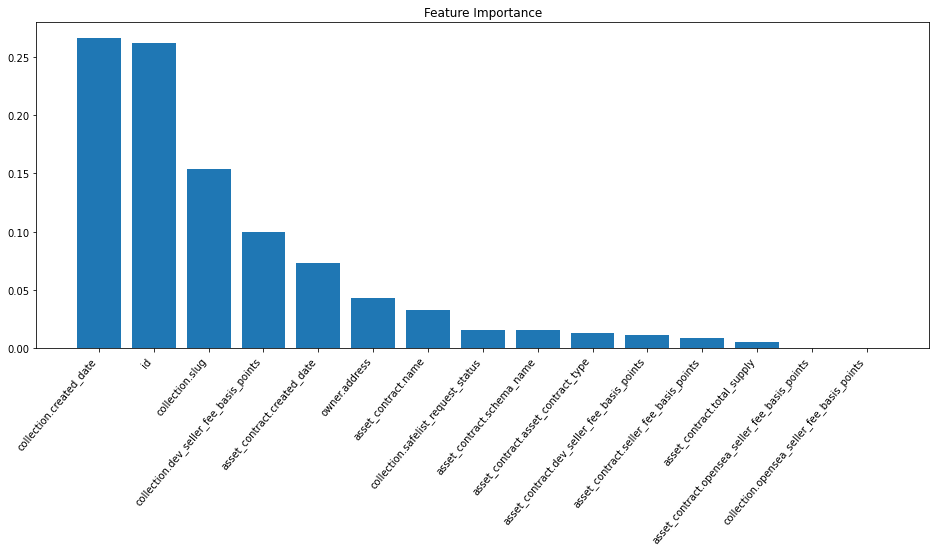

In [74]:
plot_feature_imp(gs_rand_forest.best_estimator_, conv_nft_df)

### Results 

The random Forest model produced the best model with 93% accuracy on the test data. However the precision and recall were almost perfect. That is an indication of the model picking a specific sets of columns to analyse.

## Next step

- We need to gather more data from other secondary markets as well and do an extensive analysis of indicators of this token with open sea. And cross reference some attributes not in OpenSea. 
- Also, we need to increase the number of attributes, and keep some attributes that were dropped. 
- Change the way the data are processed and what kind of models to use.